<a href="https://colab.research.google.com/github/SERVIR/GEDI_Earthhub_ARSET_Training/blob/main/Module_II_Exploring_Forest_Structure_with_GEDI_L2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module II: Exploring Forest Structure with GEDI L2B

run the pip install to to load the needed packages

re-run the cell if/when the restart prompt is given

In [1]:
!pip install earthaccess harmony-py hvplot folium geopandas

Make a new folder to work in and change directory to that location

In [34]:
!mkdir Module_2_GEDI_L2b

!mkdir Module_2_GEDI_L2b/SPB_AOI
!mkdir Module_2_GEDI_L2b/Prescribed_Burn_AOI
!mkdir Module_2_GEDI_L2b/Sewanee_Domain
!mkdir Module_2_GEDI_L2b/PaintRock_AOI

mkdir: cannot create directory ‘Module_2_GEDI_L2b/PaintRock_AOI’: No such file or directory


In [36]:
%cd /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b


https://drive.google.com/drive/folders/1kWSLWgvJs30Cj1wWUBcSIG43I7hX4KeT

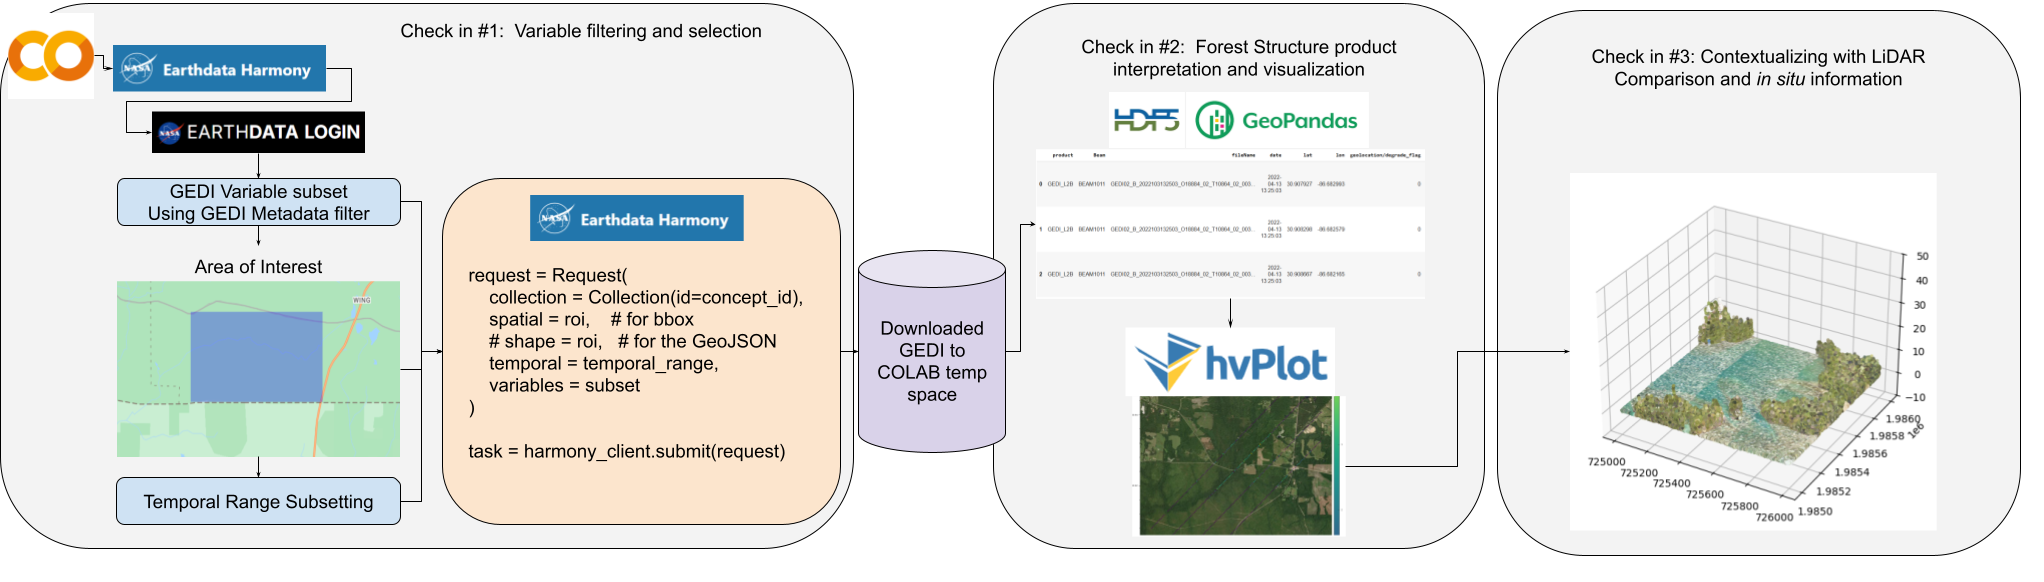

Link to editable workflow (to be removed at the end) https://docs.google.com/drawings/d/1q49Oa-y9W5X25_Qijg0IuSczzcVrcOX5mVfiyIO_UmE/edit

## Authenticate

In [4]:
from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import os
from IPython.display import JSON
import h5py
import pandas as pd
from shapely.geometry import Point
import hvplot.pandas
import folium
from folium import GeoJson
from IPython.display import display, HTML
import requests
from io import StringIO

os.chdir('../../')

[EarthData Login](https://urs.earthdata.nasa.gov/) If you dont have an account yet. Pause here and set up your arorund and have your username and password ready for this next section

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials stored in a .netrc file and allows users to type their credentials and persist them to a .netrc file if one does not exist.

In [5]:
auth = earthaccess.login(persist=True)
# auth.token

Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object.

In [6]:
harmony_client = Client(auth=(auth.username, auth.password))

# Visualize our Areas of intres (AOI)

Add relivant phyphysical and forest informaiton regarind these sites see  the folder here with the docs to support this: https://drive.google.com/drive/folders/1WvBSUIHy6I05j8s1ZZRarho5qnG2wdnb

In [7]:
#bring in aois
geojson_urls = {
    "SPB_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/SPB_AOI.geojson",
    "Prescribed_Burn_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/prescribed_burn_aoi.geojson",
    "Sewanee_Domain": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/Sewanee_Domain.geojson",
    "PaintRockAOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/PaintRockAOI.geojson"
}

In [8]:
# Load GeoJSONs into GeoDataFrames and store map HTML
geojson_gdfs = {}
maps_html = []

def create_map_and_gdf(name, url):
    # Get GeoJSON from URL
    geojson_data = requests.get(url).json()

    # Create GeoDataFrame
    gdf = gp.GeoDataFrame.from_features(geojson_data["features"])
    geojson_gdfs[name] = gdf

    # Determine map center
    coords = geojson_data['features'][0]['geometry']['coordinates']
    geom_type = geojson_data['features'][0]['geometry']['type']

    if geom_type == "Polygon":
        coords = coords[0]
    elif geom_type == "MultiPolygon":
        coords = coords[0][0]
    else:
        raise ValueError(f"Unsupported geometry type: {geom_type}")

    lat = sum(pt[1] for pt in coords) / len(coords)
    lon = sum(pt[0] for pt in coords) / len(coords)

    # Create map
    fmap = folium.Map(location=[lat, lon], zoom_start=13, tiles="OpenStreetMap")
    folium.GeoJson(geojson_data, name=name).add_to(fmap)

    # Return rendered HTML
    return fmap._repr_html_()

# Generate maps and GeoDataFrames
for name, url in geojson_urls.items():
    html_map = create_map_and_gdf(name, url)
    maps_html.append(html_map)


In [9]:
# Display maps side by side
html = f"""
<div style="display: flex; flex-wrap: wrap;">
    {''.join([f'<div style="flex: 1; min-width: 400px; margin: 5px;">{m}</div>' for m in maps_html])}
</div>
"""
display(HTML(html))

In [37]:
SPB_AOI = geojson_gdfs["SPB_AOI"]
Prescribed_Burn_AOI = geojson_gdfs["Prescribed_Burn_AOI"]
Sewanee_Domain = geojson_gdfs["Sewanee_Domain"]
PaintRock_AOI = geojson_gdfs["PaintRockAOI"]

## Get the GEDI Collections Harmoney Capabilities

Let us start by submitting a capabilities request to see the transformation supported in Harmony API using the GEDI product short names ('GEDI02_A', 'GEDI02_B', 'GEDI01_B'). Besides the `conceptId` and available variables, You can view the supported transformation services. Supported transformation services and variables (such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.) have `True` value. Based on the returned capabilities information for GEDI , we can submit a variable subsetting request, bounding box/shapefile subsetting, and temporal subsetting.

In [11]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "temporalSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_al

## Create a Harmony Request

There are several parameters that can be used for the Harmony request. See [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details.



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository [(CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections.

Below, `concept_id` is saved to a variable.  

In [12]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']
print("concept_id:", concept_id)

GEDI02_B , C2142776747-LPCLOUD
concept_id: C2142776747-LPCLOUD


### GEDI Variable Subset

In [13]:
#See the append_field.txt which hasd a long dictionary of the fields and products of GEDI
append_url = "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/append_field.txt"
append_text = requests.get(append_url).text

start_index = append_text.find("{")
end_index = append_text.rfind("}") + 1
dict_str = append_text[start_index:end_index]

append_dict = eval(dict_str)

In [14]:
#Display the dictionary we will use to sort later
append_dict

{'GEDI_L1B': ['geolocation/altitude_instrument',
  'geolocation/local_beam_elevation',
  'tx_sample_start_index',
  'nsemean_odd',
  'ancillary/master_time_epoch',
  'noise_stddev_corrected',
  'tx_pulseflag',
  'geolocation/longitude_bin0_error',
  'selection_stretchers_x',
  'nsemean_even',
  'geolocation/latitude_instrument',
  'geolocation/digital_elevation_model',
  'geolocation/longitude_instrument_error',
  'geolocation/longitude_lastbin_error',
  'tx_egsigma',
  'geolocation/neutat_delay_total_bin0',
  'rx_energy',
  'master_frac',
  'rx_sample_count',
  'rxwaveform',
  'tx_gloc',
  'ancillary/mean_samples',
  'geolocation/longitude_instrument',
  'tx_eggamma_error',
  'rx_offset',
  'tx_egbias_error',
  'geolocation/bounce_time_offset_lastbin',
  'all_samples_sum',
  'geophys_corr/tide_load',
  'geolocation/solar_azimuth',
  'geolocation/mean_sea_surface',
  'geolocation/neutat_delay_total_lastbin',
  'th_left_used',
  'rx_sample_start_index',
  'geophys_corr/tide_ocean',
  'g

In [15]:
######## print only the dictionary fo avaible GEDI 2 B products to explore
gedi_l2b = append_dict.get('GEDI_L2B', {})

# Step 4: Print items under 'GEDI_L2B'
print("Items under 'GEDI_L2B':")
for item in gedi_l2b:
    print(item)

Items under 'GEDI_L2B':
rx_processing/rg_eg_flag_a4
rx_processing/rg_eg_gamma_error_a5
rx_processing/rg_eg_gamma_error_a1
rx_processing/rg_error_a3
rx_processing/rg_eg_amplitude_a2
geolocation/local_beam_elevation
ancillary/rg_eg_constraint_center_buffer
rx_processing/rx_energy_a6
ancillary/tx_noise_stddev_multiplier
pgap_theta_z
rx_processing/rg_eg_center_error_a5
rx_processing/pgap_theta_a4
land_cover_data/modis_nonvegetated
geolocation/longitude_bin0_error
rx_processing/rg_error_a1
geolocation/elev_highestreturn
land_cover_data/landsat_water_persistence
land_cover_data/leaf_on_doy
rx_processing/algorithmrun_flag_a5
geolocation/lon_lowestmode
rx_processing/rx_energy_a4
geolocation/digital_elevation_model
rhov
rx_processing/rg_a5
rx_processing/rg_error_a2
geolocation/longitude_lastbin_error
rx_processing/rg_a6
rx_processing/rg_eg_gamma_a1
l2b_quality_flag
rx_processing/rg_eg_amplitude_error_a4
rx_processing/rg_eg_amplitude_a3
rx_processing/pgap_theta_error_a3
land_cover_data/leaf_off_

Select your variables of intrest

In [16]:
subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'lat_highestreturn', 'geolocation/lon_highestreturn', 'geolocation/elev_highestreturn', 'l2b_quality_flag', 'rh100', 'pai', 'pai_z', 'pavd_z']

In [17]:
### filter those out of the larger list
selected_L2B = []
for s in subset_L2B:
    my_var = [v for v in gedi_l2b if v.endswith(f'{s}')]
    if len(my_var) == 1:
        selected_L2B.append(my_var[0])

    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]

        for l in my_var:
            if l not in selected_L2B:
                selected_L2B.append(l)

selected_L2B

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/degrade_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/lat_highestreturn',
 'geolocation/lon_highestreturn',
 'geolocation/elev_highestreturn',
 'l2b_quality_flag',
 'rh100',
 'pai',
 'pai_z',
 'pavd_z']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [18]:
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']  #['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

In [19]:
# Append our beams of intrest to our variables of intrest
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in selected_L2B]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/lat_highestreturn',
 '/BEAM0101/geolocation/lon_highestreturn',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/rh100',
 '/BEAM0101/pai',
 '/BEAM0101/pai_z',
 '/BEAM0101/pavd_z',
 '/BEAM0110/geolocation/lat_lowestmode',
 '/BEAM0110/geolocation/lon_lowestmode',
 '/BEAM0110/geolocation/degrade_flag',
 '/BEAM0110/geolocation/digital_elevation_model',
 '/BEAM0110/geolocation/elev_lowestmode',
 '/BEAM0110/geolocation/lat_highestreturn',
 '/BEAM0110/geolocation/lon_highestreturn',
 '/BEAM0110/geolocation/elev_highestreturn',
 '/BEAM0110/l2b_quality_flag',
 '/BEAM0110/rh100',
 '/BEAM0110/pai',
 '/BEAM0110/pai_z',
 '/BEAM0110/pavd_z',
 '/BEAM1000/geolocation/lat_lowestmode',
 '/BEAM1000/geolocation/lon_lowestmode',
 '/BEA

### Spatial Subset

Both `spatial` and` shape` are the query parameters used for spatial subsetting using bounding box and shapefile/GeoJSON respectively. For the Bounding box, the Harmony `Bbox` class accepts spatial coordinates as decimal degrees in the order of west, south, east, and north coordinates (e.g.(-119.205104, 36.012018, -117.907297, 37.054834)). For the spatial subset using a region of interest, the path to a GeoJSON file (.json or .geojson), an ESRI Shapefile (.zip or .shz), or a kml file (.kml) as `shape` param are acceptable inputs.

In [38]:
SPB_AOI_roi = BBox(-87.41249365706668, 34.14940566292299, -87.35970778365359, 34.1864759501938)
Prescribed_Burn_AOI_roi = BBox(-86.68320982, 30.99529573, -86.62706739, 31.02423368)
Sewanee_Domain_AOI_roi = BBox(-85.98971714751701,-85.98971714751701, -85.85727611112807, 35.235639374867105)
PaintRock_AOI_roi = BBox(-86.31006140840377,34.769532701151896, -86.30307836070996, 34.77524552146644)

### Temporal Subset

For temporal subsetting, the data temporal start and end ranges are used as a datetime object. Below, the start and end dates for the query are selected.

In [39]:
temporal_range = {'start': datetime(2022, 4, 1),
                  'stop': datetime(2022, 6, 1)}

In [29]:
request = Request(
    collection = Collection(id=concept_id),
    spatial = SPB_AOI_roi,
    temporal = temporal_range,
    variables = subset
)

print("Check if the request payload per aoi:", request.is_valid())

task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)

results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/SPB_AOI', overwrite=True)

file_names = [f.result() for f in results]

In [44]:
temporal_range = {'start': datetime(2022, 4, 1),
                  'stop': datetime(2022, 12, 1)}

request = Request(
    collection = Collection(id=concept_id),
    spatial = Prescribed_Burn_AOI_roi,
    temporal = temporal_range,
    variables = subset
)

print("Check if the request payload per aoi:", request.is_valid())

task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)

results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI', overwrite=True)
results
file_names = [f.result() for f in results]

Check if the request payload per aoi: True
Harmony request ID: 25ae8668-e1e5-4a86-b1f6-13ad47ceba7e
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]

There is no file to download.

Job status is successful with message: The job succeeded with 4 warnings. See the warnings field of the job status page for more details..


In [41]:
request = Request(
    collection = Collection(id=concept_id),
    spatial = PaintRock_AOI_roi,
    temporal = temporal_range,
    variables = subset
)

print("Check if the request payload per aoi:", request.is_valid())

task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)

results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/PaintRock_AOI', overwrite=True)

file_names = [f.result() for f in results]

Check if the request payload per aoi: True
Harmony request ID: a3dbeb1f-9a08-4976-95d3-8edfa381e716
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]

There is no file to download.

Job status is successful with message: The job succeeded with 2 warnings. See the warnings field of the job status page for more details..


In [42]:
request = Request(
    collection = Collection(id=concept_id),
    spatial = Sewanee_Domain_AOI_roi,
    temporal = temporal_range,
    variables = subset
)

print("Check if the request payload per aoi:", request.is_valid())

task = harmony_client.submit(request)
print(f'Harmony request ID: {task}')

print(f'Processing your Harmony request:')
task_json = harmony_client.result_json(task, show_progress=True)

results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/Sewanee_Domain', overwrite=True)

file_names = [f.result() for f in results]

Check if the request payload per aoi: True
Harmony request ID: cf8ac1c6-c77a-4355-b3ce-33eddd4e9707
Processing your Harmony request:


 [ Processing:   9% ] |####                                               | [|]
Job has been paused. Call `resume()` to resume.
 [ Processing: 100% ] |###################################################| [|]
Job has been paused. Call `resume()` to resume.


/content/Module_2_GEDI_L2b/Sewanee_Domain/102272844_GEDI02_B_2022091055115_O18693_04_T06939_02_003_01_V002_subsetted.h5


Finally, submit the request and retrieve list of the processed data URLs once processing is complete. You may optionally show the progress bar below.

In [32]:
# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

# results = harmony_client.download_all(task, directory='/content/Module_2_GEDI_L2b/SPB_AOI', overwrite=True)

Harmony request ID: ed7b296b-7273-486f-bb1c-9bf97c90ac52
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


In [33]:
# file_names = [f.result() for f in results]

/content/Module_2_GEDI_L2b/SPB_AOI/102271130_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102271129_GEDI02_B_2022093011111_O18721_03_T01627_02_003_01_V002_subsetted.h5


In [27]:
# task_1 = harmony_client.submit(requests[0])
# print(f'Harmony request ID: {task_1}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task_1, show_progress=True)

# results_1 = harmony_client.download_all(task_1, directory='/content/Module_2_GEDI_L2b/SPB_AOI', overwrite=True)
# ####
# task_2 = harmony_client.submit(requests[1])
# print(f'Harmony request ID: {task_2}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task_2, show_progress=True)

# results_2 = harmony_client.download_all(task_2, directory='/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI', overwrite=True)
# ####
# task_3 = harmony_client.submit(requests[2])
# print(f'Harmony request ID: {task_3}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task_3, show_progress=True)

# results_3 = harmony_client.download_all(task_3, directory='/content/Module_2_GEDI_L2b/Sewanee_Domain', overwrite=True)
# ####
# task_4 = harmony_client.submit(requests[3])
# print(f'Harmony request ID: {task_4}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task_4, show_progress=True)

# results_4 = harmony_client.download_all(task_4, directory='/content/Module_2_GEDI_L2b/PaintRockAOI', overwrite=True)


Harmony request ID: e0307d49-3d06-44ff-8d8e-ec6032557232
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: 72afaaa6-2049-480f-8e7c-03ff2b45b96c
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: 303bfd35-33e7-4bce-8661-35f3a6d35f63
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]
 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: e8077ba4-97a0-4d9b-a8c6-bd7decf6ec28
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


<generator object Client.download_all at 0x7b466bc7ba70>

In [28]:
!find /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b
/content/Module_2_GEDI_L2b/Sewanee_Domain
/content/Module_2_GEDI_L2b/SPB_AOI
/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
/content/Module_2_GEDI_L2b/PaintRockAOI


In [ ]:
file_names = [f.result() for f in results]

In [ ]:
# tasks = []

# for idx, req in enumerate(requests):
#     print(f"\nSubmitting Request {idx + 1} (at {hex(id(req))})...")
#     try:
#         task = harmony_client.submit(req)
#         print(f"Harmony request ID {idx + 1}: {task}")

#         print(f"Processing Harmony request {idx + 1}...")
#         task_json = harmony_client.result_json(task, show_progress=True)

#         tasks.append((task, task_json))

#     except Exception as e:
#         print(f"❌ Request {idx + 1} failed: {e}")
#         tasks.append((None, None))  # Or store error info

In [ ]:
# tasks

In [161]:
# #create a task per aoi for downloading
# tasks = []

# for idx, req in enumerate(requests):
#     print(f"\nSubmitting Request {idx + 1} (at {hex(id(req))})...")
#     task = harmony_client.submit(req)
#     print(f"Harmony request ID {idx + 1}: {task}")

#     print(f"Processing Harmony request {idx + 1}...")
#     task_json = harmony_client.result_json(task, show_progress=True)

#     tasks.append((task, task_json))  # Save if you want to reference later


Submitting Request 1 (at 0x7deac0e17bd0)...
Harmony request ID 1: 34536181-de9a-44e3-a2c1-af8a6aba85ed
Processing Harmony request 1...


 [ Processing: 100% ] |###################################################| [|]



Submitting Request 2 (at 0x7deac0e160d0)...
Harmony request ID 2: 29faed56-6364-4fbd-957d-f427c6abd04e
Processing Harmony request 2...


 [ Processing: 100% ] |###################################################| [|]



Submitting Request 3 (at 0x7deabc6ec3d0)...


Exception: ('Bad Request', 'Error: No matching granules found.')

In [ ]:
# task = harmony_client.submit(request)
# print(f'Harmony request ID: {task}')

# print(f'Processing your Harmony request:')
# task_json = harmony_client.result_json(task, show_progress=True)

Harmony request ID: 43390290-b0df-4c80-8df9-2c76457e7c95
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


Next, download the subset of data.

In [26]:
### download for each AOI
for i in tasks:
  results = harmony_client.download_all(i, directory='/content/Module_2_GEDI_L2b', overwrite=True)
  print(i)

('7b49dbf9-1f30-4655-9570-eff1b1a7a7fa', {'username': 'tjm0042', 'status': 'successful', 'message': 'The job has completed successfully', 'progress': 100, 'createdAt': '2025-06-18T17:41:18.408Z', 'updatedAt': '2025-06-18T17:41:36.625Z', 'dataExpiration': '2025-07-18T17:41:18.408Z', 'links': [{'title': 'STAC catalog', 'href': 'https://harmony.earthdata.nasa.gov/stac/7b49dbf9-1f30-4655-9570-eff1b1a7a7fa/', 'rel': 'stac-catalog-json', 'type': 'application/json'}, {'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/7b49dbf9-1f30-4655-9570-eff1b1a7a7fa/102266766/GEDI02_B_2022093011111_O18721_03_T01627_02_003_01_V002_subsetted.h5', 'title': 'GEDI02_B_2022093011111_O18721_03_T01627_02_003_01_V002_subsetted.h5', 'type': 'application/x-hdf5', 'rel': 'data', 'bbox': [-142.74422704, 0.39288138, -58.26000755, 52.05362218], 'temporal': {'start': '2022-04-03T01:11:11.000Z', 'end': '2022-04-03T02:44:03.000Z'}}, {'href': 'https://harmony.earthdata.nasa.gov/service-

ddddddddddddddddddddddddddddddddddddddddddd

In [29]:
import os
from harmony import BBox, Request, Collection

# ----- Step 1: Prepare AOIs -----
aoi_list = [SPB_AOI, Prescribed_Burn_AOI, Sewanee_Domain, PaintRockAOI]
rois = [BBox(*gdf.total_bounds) for gdf in aoi_list]

# ----- Step 2: Create Harmony requests -----
requests = []
for roi in rois:
    req = Request(
        collection=Collection(id=concept_id),  # Replace with your CMR Collection ID
        spatial=roi,
        temporal=temporal_range,              # Tuple: ("YYYY-MM-DD", "YYYY-MM-DD")
        variables=subset                      # List of variable paths
    )
    requests.append(req)

# ----- Step 3: Submit requests & track tasks -----
tasks = []

for idx, req in enumerate(requests):
    print(f"\n🚀 Submitting Request {idx + 1} (at {hex(id(req))})...")
    task = harmony_client.submit(req)
    print(f"✅ Submitted: Job ID {task.request_id}")

    print(f"⏳ Waiting for Harmony job {idx + 1} to complete...")
    task_json = harmony_client.result_json(task, show_progress=True)

    tasks.append((task, task_json))

# ----- Step 4: Download all results -----
output_dir = '/content/Module_2_GEDI_L2b'

for idx, (task, task_json) in enumerate(tasks):
    print(f"\n📥 Downloading results for Task {idx + 1} (Job ID: {task.request_id})...")

    results = harmony_client.download_all(task, directory=output_dir, overwrite=True)

    if not results:
        print(f"⚠️ No files downloaded for Task {idx + 1}")
    else:
        print(f"✅ Downloaded {len(results)} file(s) for Task {idx + 1}:")
        for path in results:
            size_mb = os.path.getsize(path) / (1024 * 1024)
            print(f"   - {os.path.basename(path)} ({size_mb:.2f} MB)")



🚀 Submitting Request 1 (at 0x7892f0d15c10)...


AttributeError: 'str' object has no attribute 'request_id'

In [ ]:
# results = harmony_client.download_all(task, directory='content', overwrite=True)

In [184]:
file_names = [f.result() for f in results]
file_names

[]

Function is defined to create a DataFrame from our HDF5 Harmony subset file. Next, `GeoDataFrame` is created for all the downloaded subset file.

In [ ]:
def h5_to_dataframe(ds, beams, vars):
    """
    This function takes Harmony subset of GEDI hdf5 and returns a DataFrame.
    """
    #read the dataset
    gedi_ds = h5py.File(ds,'r')
    # see what is the data product
    product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
    fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
    date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
    # Create an empty DataFrame for this beam
    df_beam = pd.DataFrame(columns=vars)

    for b in beams:
        data_dic = {}
        for v in vars:
            # print(b,v)
            value = gedi_ds[f'{b}/{v}'][()]
            data_dic[v] = value.tolist()

        df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")

        # add product, beam, file name, and date columns
        df_beam.insert(0, 'product', product)
        df_beam.insert(1, 'Beam', b)
        df_beam.insert(2, 'fileName' , fileName)
        df_beam.insert(3, 'date', date)

    return(df_beam.reset_index(drop=True))


In [ ]:
l2b_df = pd.DataFrame()

for file in file_names:
    print(file)
    gedi_subset = h5_to_dataframe(file, beams, datasets_p)
    l2b_df = gp.GeoDataFrame(pd.concat([l2b_df, gedi_subset]))
    del gedi_subset

# Reset the indeces
l2b_df = l2b_df.reset_index(drop=True)
l2b_df = l2b_df.rename(columns={'geolocation/lat_lowestmode': 'lat', 'geolocation/lon_lowestmode': 'lon'})
 # Take the lat/lon from DataFrame and convert each lat/lon to a shapely point and convert to a GeoDataFrame
l2b_df = gp.GeoDataFrame(l2b_df, geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1))


content/101258389_GEDI02_B_2022103132503_O18884_02_T10864_02_003_01_V002_subsetted.h5


<ipython-input-22-4a505d0ee717>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, pd.DataFrame(data_dic)],join="inner")


In [ ]:
l2b_df.head()

,product,Beam,fileName,date,lat,lon,geolocation/degrade_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/lat_highestreturn,geolocation/lon_highestreturn,geolocation/elev_highestreturn,l2b_quality_flag,rh100,pai,pai_z,pavd_z,geometry
0,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.907927,-86.682993,0,26.355474,59.715824,30.907927,-86.682993,59.715824,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68299 30.90793)
1,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.908298,-86.682579,0,28.530102,60.324383,30.908298,-86.682579,60.324383,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68258 30.9083)
2,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.908667,-86.682165,0,28.530102,60.202522,30.908667,-86.682165,60.202522,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68216 30.90867)
3,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.909037,-86.681750,0,28.677153,60.551300,30.909037,-86.681750,60.551300,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68175 30.90904)
4,GEDI_L2B,BEAM1011,GEDI02_B_2022103132503_O18884_02_T10864_02_003...,2022-04-13 13:25:03,30.909407,-86.681336,0,28.677153,60.544659,30.909407,-86.681336,60.544659,0,0,-9999.0,"[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...","[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0, ...",POINT (-86.68134 30.90941)


In [ ]:
l2b_df.hvplot(cmap='viridis', clim=(0,l2b_df['pai'].max()), color='pai', size=10, frame_width=900, geo=True, tiles='ESRI')

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (pai)

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 02-20-2024  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  